Выберите ряд из первого задания, постройте его модель ARIMA.

Попробуйте спрогнозировать график классическим ML.

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.ar_model as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [53]:
dowjones = pd.read_csv("weekly-closings-of-the-dowjones-.csv", index_col = 'Week', parse_dates = True, dayfirst=True)
dowjones.head(2)

,Close
Week,
1971-W27,890.19
1971-W28,901.80


Text(0.5, 1.0, 'Weekly closings of the dowjones')

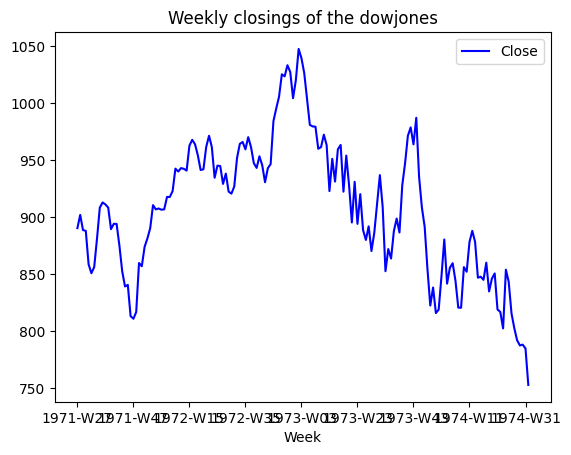

In [54]:
dowjones.plot(color='blue')
plt.title('Weekly closings of the dowjones')

In [35]:
print(adfuller(dowjones['Close']))

(-1.3146254984911683, 0.6224548515589733, 0, 161, {'1%': -3.471633386932248, '5%': -2.8796651107461972, '10%': -2.576433647235832}, 1303.5058705610606)


In [36]:
model = ARIMA(dowjones['Close'], order=(3, 2, 2)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  162
Model:                 ARIMA(3, 2, 2)   Log Likelihood                -705.524
Date:                Tue, 30 May 2023   AIC                           1423.047
Time:                        13:23:39   BIC                           1441.499
Sample:                             0   HQIC                          1430.540
                                - 162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7449      0.226     -3.290      0.001      -1.189      -0.301
ar.L2         -0.0006      0.104     -0.006      0.995      -0.205       0.203
ar.L3          0.1259      0.086      1.461      0.1

In [37]:
print(model.resid.describe())

count    162.000000
mean       1.731373
std       80.482657
min     -433.475044
25%      -13.908969
50%       -0.552255
75%       10.302303
max      890.190000
dtype: float64


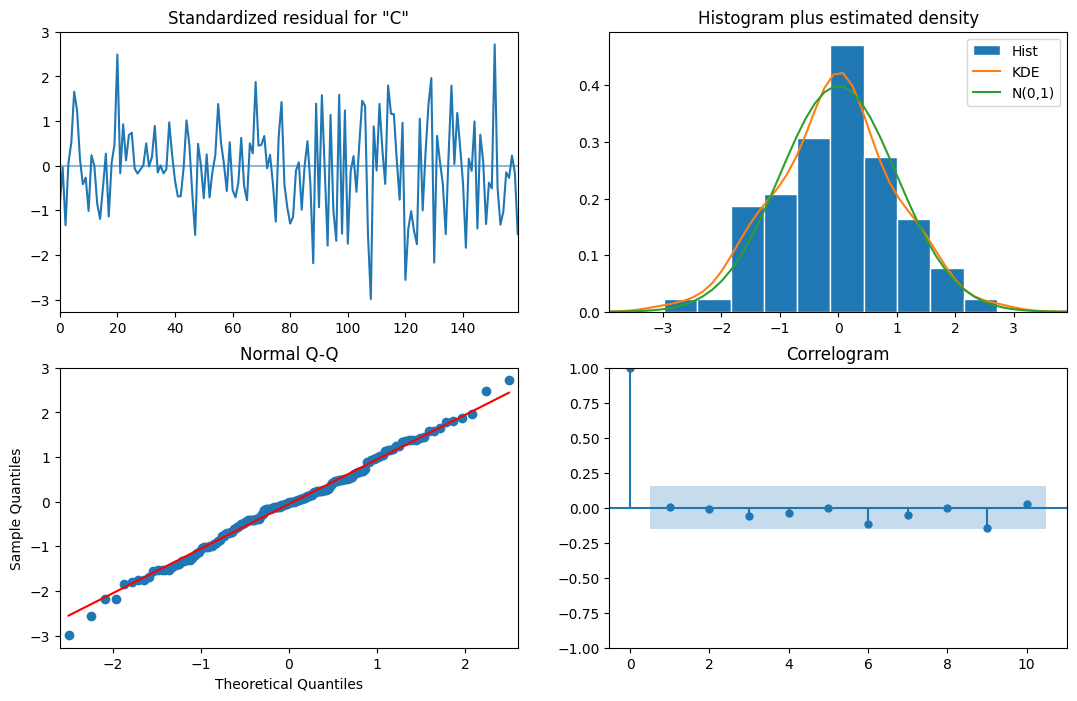

In [22]:
model.plot_diagnostics(figsize=(13, 8))
plt.show()

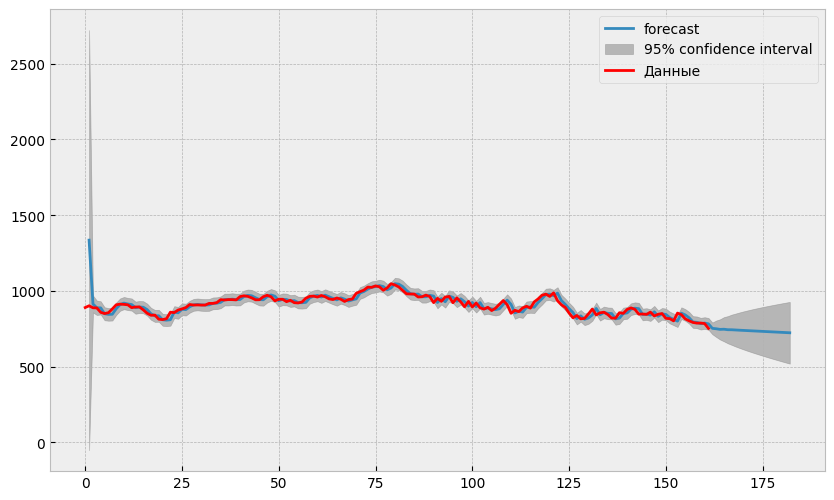

In [23]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10,6))
    ax = plt.axes()
    plot_predict(model, 1, len(dowjones)+20, ax=ax)
    plt.plot(dowjones, color='red', label='Данные')
    plt.legend()
    plt.show()

In [38]:
# попробую дополнительно убрать тренд
diff_ = np.diff(dowjones.Close)

In [39]:
model_two = ARIMA(diff_, order=(3,2,2)).fit()
print(model_two.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  161
Model:                 ARIMA(3, 2, 2)   Log Likelihood                -724.824
Date:                Tue, 30 May 2023   AIC                           1461.648
Time:                        13:24:07   BIC                           1480.061
Sample:                             0   HQIC                          1469.125
                                - 161                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4841      0.392     -3.783      0.000      -2.253      -0.715
ar.L2         -0.8927      0.330     -2.705      0.007      -1.540      -0.246
ar.L3         -0.2423      0.193     -1.253      0.2

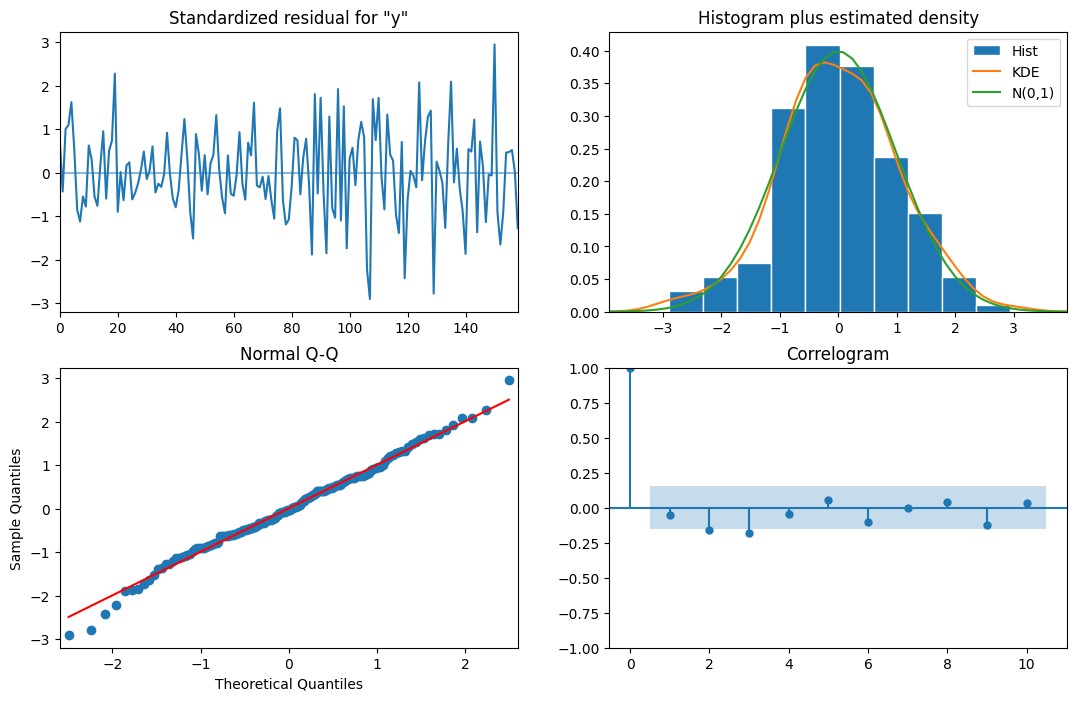

In [40]:
model_two.plot_diagnostics(figsize=(13, 8))
plt.show()

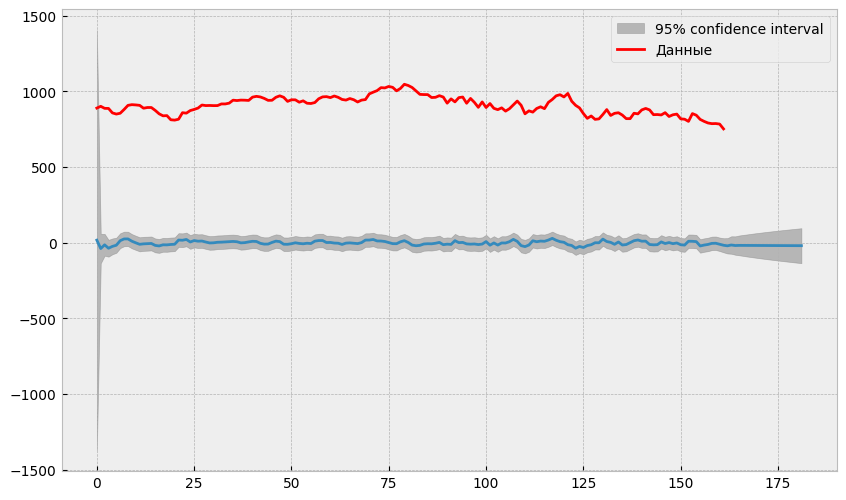

In [28]:
# лишнее преобразование было не очень хорошей идеей

with plt.style.context('bmh'):
    plt.figure(figsize=(10,6))
    ax = plt.axes()
    plot_predict(model_two, 1, len(dowjones)+20, ax=ax)
    plt.plot(dowjones, color='red', label='Данные')
    plt.legend()
    plt.show()

In [15]:
# Попробую код с лекции с подбором коэффициентов

In [16]:
def tsplot(y, lags=None, figsize=(10, 6), style='bmh'):
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

aic: 1416.32751 | order: (2, 2, 3)


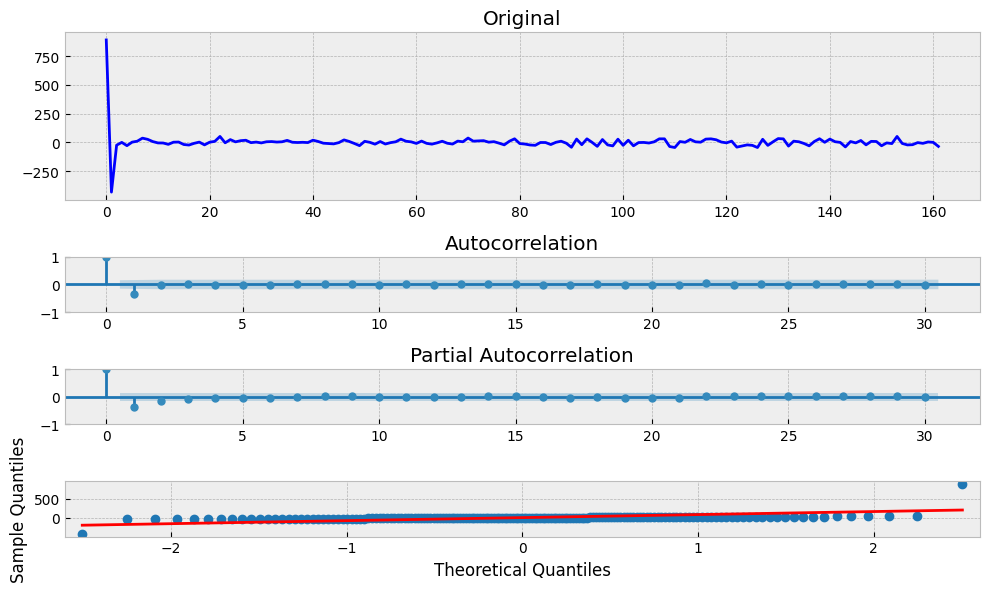

In [42]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(dowjones['Close'], order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print(f'aic: {best_aic:6.5f} | order: {best_order}')
tsplot(best_mdl.resid, lags=30)

In [43]:
print(best_mdl.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  162
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -702.164
Date:                Tue, 30 May 2023   AIC                           1416.328
Time:                        13:31:27   BIC                           1434.779
Sample:                             0   HQIC                          1423.820
                                - 162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5989      0.060    -26.743      0.000      -1.716      -1.482
ar.L2         -0.9298      0.052    -17.904      0.000      -1.032      -0.828
ma.L1          0.5756      0.771      0.747      0.4

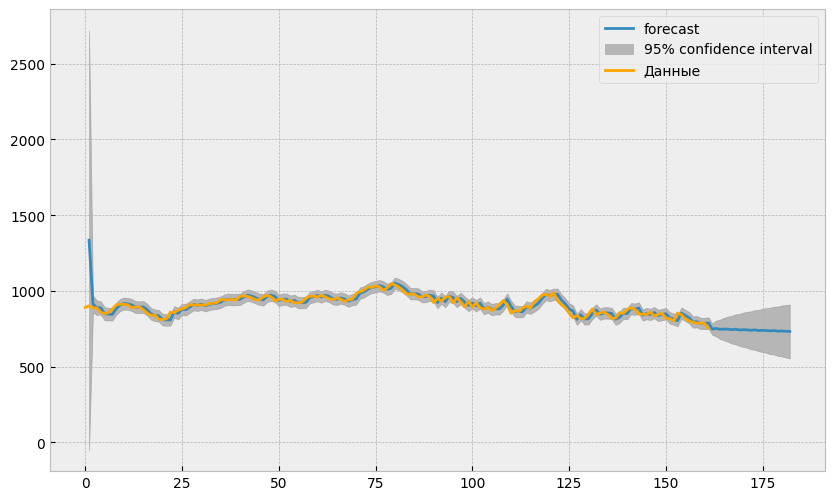

In [45]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10,6))
    ax = plt.axes()
    plot_predict(best_mdl, 1, len(dowjones)+20, ax=ax)
    plt.plot(dowjones['Close'], color='orange', label='Данные')
    plt.legend()
    plt.show()

In [113]:
def traintestsplit(data, lag_start=0, lag_end=10):
    
   for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
  
   data = data.dropna()
   data = data.reset_index(drop=True)
  
   X_train = data.loc[:130].drop(['Close'], axis=1)
   y_train = data.loc[:130]['Close']
   X_test = data.loc[130:].drop(['Close'], axis=1)
   y_test = data.loc[130:]['Close']
    
   return X_train, X_test, y_train, y_test

In [114]:
X_train, X_test, y_train, y_test = traintestsplit(dowjones)

In [115]:
len(X_train), len(X_test), len(y_train), len(y_test)

(131, 13, 131, 13)

In [119]:
print(X_train)

      lag_5   lag_6   lag_7   lag_8   lag_9  lag_10  lag_11  lag_12  lag_13  \
0    893.91  893.98  889.31  908.22  911.00  912.75  908.15  880.91  856.02   
1    874.85  893.91  893.98  889.31  908.22  911.00  912.75  908.15  880.91   
2    852.37  874.85  893.91  893.98  889.31  908.22  911.00  912.75  908.15   
3    839.00  852.37  874.85  893.91  893.98  889.31  908.22  911.00  912.75   
4    840.39  839.00  852.37  874.85  893.91  893.98  889.31  908.22  911.00   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
126  878.05  851.92  855.99  820.32  820.40  843.94  859.39  855.47  841.48   
127  887.83  878.05  851.92  855.99  820.32  820.40  843.94  859.39  855.47   
128  878.13  887.83  878.05  851.92  855.99  820.32  820.40  843.94  859.39   
129  846.68  878.13  887.83  878.05  851.92  855.99  820.32  820.40  843.94   
130  847.54  846.68  878.13  887.83  878.05  851.92  855.99  820.32  820.40   

     lag_14  lag_15  lag_16  lag_17  lag_18  lag_19

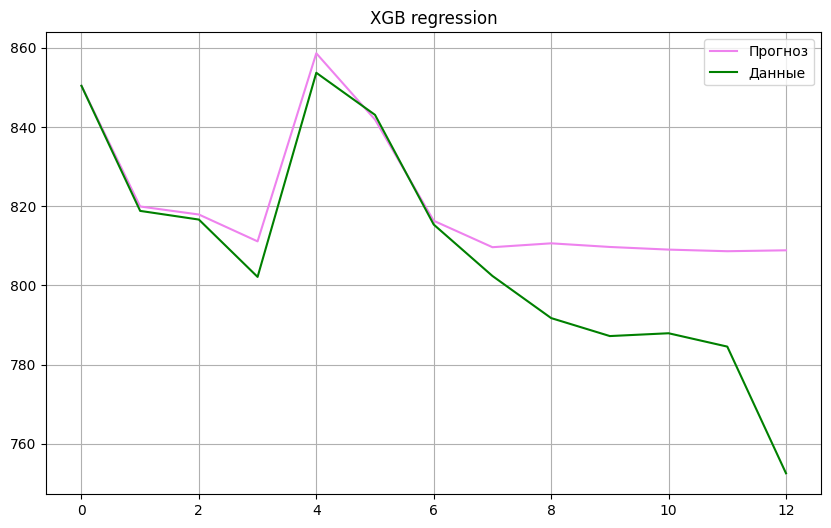

In [124]:
xgbr = XGBRegressor().fit(X_train, y_train)
prediction = xgbr.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(prediction, color='violet', label='Прогноз')
plt.plot(y_test.values, color='green', label='Данные')
plt.legend()
plt.title("XGB regression")
plt.grid(True);

In [121]:
rmse = np.sqrt(mean_squared_error(prediction, y_test))
print(f'Ошибка составляет: {round(rmse, 2)}')

Ошибка составляет: 20.04
